In [94]:
import numpy as np 
import matplotlib.pyplot as plt
from statistics import mean
from scipy import constants as cst
from scipy import signal
from scipy.stats import linregress
from scipy.signal import find_peaks, peak_prominences
from scipy.signal import freqz, lfilter, welch
from scipy import fftpack
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import math
from scipy.constants import find, physical_constants, c
import datetime
import scipy.special
from math import factorial

In [95]:
def compute_k(wavelength):
    return 2 * np.pi / wavelength

def generate_grid(L, grid_size):
    return np.linspace(-L / 2, L / 2, grid_size)


In [96]:

# Phase Screen for Cartesian Coordinates
class PhaseScreenDec:
    def __init__(self, wavelength, phi0, r0, grid_size, L, Z_lambda):
        self.wavelength = wavelength
        self.k = compute_k(wavelength)
        self.phi0 = phi0
        self.L = L
        self.grid_size = grid_size
        self.dx = L / grid_size
        self.x = generate_grid(L, grid_size)
        self.Z_lambda = Z_lambda
        self.r0 = r0
        self.z_values = [z * wavelength for z in Z_lambda]
        self.phi = -phi0 * np.exp(-self.x**2 / r0**2)

    def check_nyquist_criterion(self):
        dphi_dx = np.gradient(self.phi, self.dx)
        nyquist_values = self.dx * np.abs(dphi_dx)
        if np.any(nyquist_values >= np.pi):
            print("Warning: Nyquist criterion isn't satisfied!")
        else:
            print("Nyquist criterion is satisfied.")

    def generation_of_phase_screen_dec(self):
        return np.exp(1j * self.phi)

    def fourier_propagation(self):
        U = self.generation_of_phase_screen_dec()
        U_fft = np.fft.fftshift(np.fft.fft(U))
        K = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(self.grid_size, d=self.dx))
        results = []

        for zi in self.z_values:
            H = np.exp(1j * zi * K**2 / (2 * self.k) + 1j * K * self.x)
            U_prop = np.exp(-1j * self.k * zi) * np.fft.ifft(np.fft.ifftshift(U_fft * H))
            results.append(np.abs(U_prop)**2)

        return results


In [97]:

# Theoretical Intensity
class ETheoretical:
    def __init__(self, phase_screen_dec):
        self.phase_screen_dec = phase_screen_dec

    def calculate_E_theoretical(self, max_n=170):
        I_theory = []
        x, k, r0, phi0 = (
            self.phase_screen_dec.x,
            self.phase_screen_dec.k,
            self.phase_screen_dec.r0,
            self.phase_screen_dec.phi0,
        )

        for zi in self.phase_screen_dec.z_values:
            summation = np.zeros_like(x, dtype=np.complex128)
            E_prefactor = (
                np.exp(1j * k * zi + 1j * k * x**2 / (2 * zi)) / np.sqrt(1j * k * zi)
            )

            for n in range(max_n):
                coef = ((1j * phi0) ** n) / factorial(n)
                denom = 2 * n / (k * r0) ** 2 - 1j / (k * zi)
                exp_arg = -x**2 / (2 * zi**2 * denom)
                summation += coef * denom**-0.5 * np.exp(exp_arg)

            I_theory.append(np.abs(E_prefactor * summation) ** 2)

        return I_theory


In [98]:

# Cylindrical Coordinates Phase Screen
class PhaseScreenCyl:
    def __init__(self, wavelength, phi0, grid_size, R, Grid_theta, r, dr_lambda, r0):
        self.wavelength = wavelength
        self.k = compute_k(wavelength)
        self.phi0 = phi0
        self.grid_size = grid_size
        self.R = R
        self.Grid_theta = Grid_theta
        self.r = r
        self.dr_lambda = dr_lambda
        self.r0 = r0
        self.dtheta = Grid_theta / grid_size
        self.theta = generate_grid(Grid_theta, grid_size)
        self.dr_values = [dr * wavelength for dr in dr_lambda]
        self.phi = -phi0 * np.exp(-((self.theta * R) ** 2) / r0**2)

    def check_nyquist_criterion_cyl(self):
        dphi_dtheta = np.gradient(self.phi, self.dtheta)
        nyquist_values = self.dtheta * np.abs(dphi_dtheta)
        if np.any(nyquist_values >= np.pi):
            print("Warning: Nyquist criterion isn't satisfied!")
        else:
            print("Nyquist criterion is satisfied.")



    def generation_of_phase_screen_cyl(self):
        K = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(self.grid_size, d=self.dtheta))
        results = []

        for dri in self.dr_values:
            U = np.ones(self.grid_size, dtype=complex)
            U = np.exp(
                -1j * (self.phi - 1 / (2 * self.k) * (1 / self.r - 1 / (self.r + dri))) + np.log((self.r + dri)/self.r)
            )
            U_fft = np.fft.fftshift(np.fft.fft(U))
            H = np.exp(-1j * K**2 / (2 * self.k) * (1 / self.r - 1 / (self.r + dri)))
            U_prop = (
                np.exp(1j * self.k * dri) / self.r * np.fft.ifft(np.fft.ifftshift(self.r*U_fft * H))
            )
            results.append(np.abs(U_prop) ** 2)

        return results


In [99]:
class PlotResults:
    
    def __init__(self, phase_screen_dec, e_theoretical, phase_screen_cyl):
        self.phase_screen_dec = phase_screen_dec
        self.e_theoretical = e_theoretical
        self.phase_screen_cyl = phase_screen_cyl
    
    # @staticmethod
    def plot_results(self):
        numerical_results = self.phase_screen_dec.fourier_propagation()
        I_theory = self.e_theoretical.calculate_E_theoretical()
        cyl_results = self.phase_screen_cyl.generation_of_phase_screen_cyl()

        fig, axs = plt.subplots(
            len(self.phase_screen_dec.z_values), 1, figsize=(10, 25), constrained_layout=True
        )
        fig.suptitle(f"Grid Size: {self.phase_screen_dec.grid_size}", fontsize=15)

        for i, (zi, num_intensity, th_intensity, cyl_intensity) in enumerate(
            zip(self.phase_screen_dec.Z_lambda, numerical_results, I_theory, cyl_results)
        ):
            axs[i].plot(
                self.phase_screen_dec.x / self.phase_screen_dec.wavelength,
                th_intensity,
                label="Theoretical",
                linewidth=4,
            )
            axs[i].plot(
                self.phase_screen_dec.x / self.phase_screen_dec.wavelength,
                num_intensity,
                label="Numerical",
                linewidth=4,
                linestyle="--",
            )
            axs[i].plot(
                self.phase_screen_cyl.theta * self.phase_screen_cyl.R / self.phase_screen_dec.wavelength,
                cyl_intensity,
                label="Cylindrical",
                linewidth=4,
                linestyle="dotted",
            )
            axs[i].set_title(f"z / λ = {zi}")
            axs[i].set_xlabel("Distance (x / λ)")
            axs[i].set_ylabel("Intensity")
            axs[i].legend()
            axs[i].set_ylim([0, 8])
            
        plt.savefig(f"{self.phase_screen_dec.grid_size}_allOverlay.png", dpi='figure')
        plt.show()


In [100]:
# Constants
R = 100  # 100 meters to source (it is radius of circle)
Grid_theta = 0.06  # radians
r = 100
grid_size = 50000
dr_lambda = [0.1, 0.3, 0.5, 0.8, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 10.0]
freq = 1e9
wavelength = 3e8 / freq
phi0 = 10  # phi0 in radians
r0 = wavelength
L = 6  # Length of the observation grid
Z_lambda = [0.1, 0.3, 0.5, 0.8, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 10.0]


In [101]:
phase_screen_dec = PhaseScreenDec(wavelength, phi0, r0, grid_size, L, Z_lambda)
phase_screen_dec.check_nyquist_criterion()  
numerical_results_dec = phase_screen_dec.fourier_propagation()  


Nyquist criterion is satisfied.


In [102]:
e_theoretical = ETheoretical(phase_screen_dec)
I_theory = e_theoretical.calculate_E_theoretical()  


In [103]:
phase_screen_cyl = PhaseScreenCyl(wavelength, phi0, grid_size, R, Grid_theta, r, dr_lambda, r0)
phase_screen_cyl.check_nyquist_criterion_cyl() 
numerical_results_cyl = phase_screen_cyl.generation_of_phase_screen_cyl()  


Nyquist criterion is satisfied.


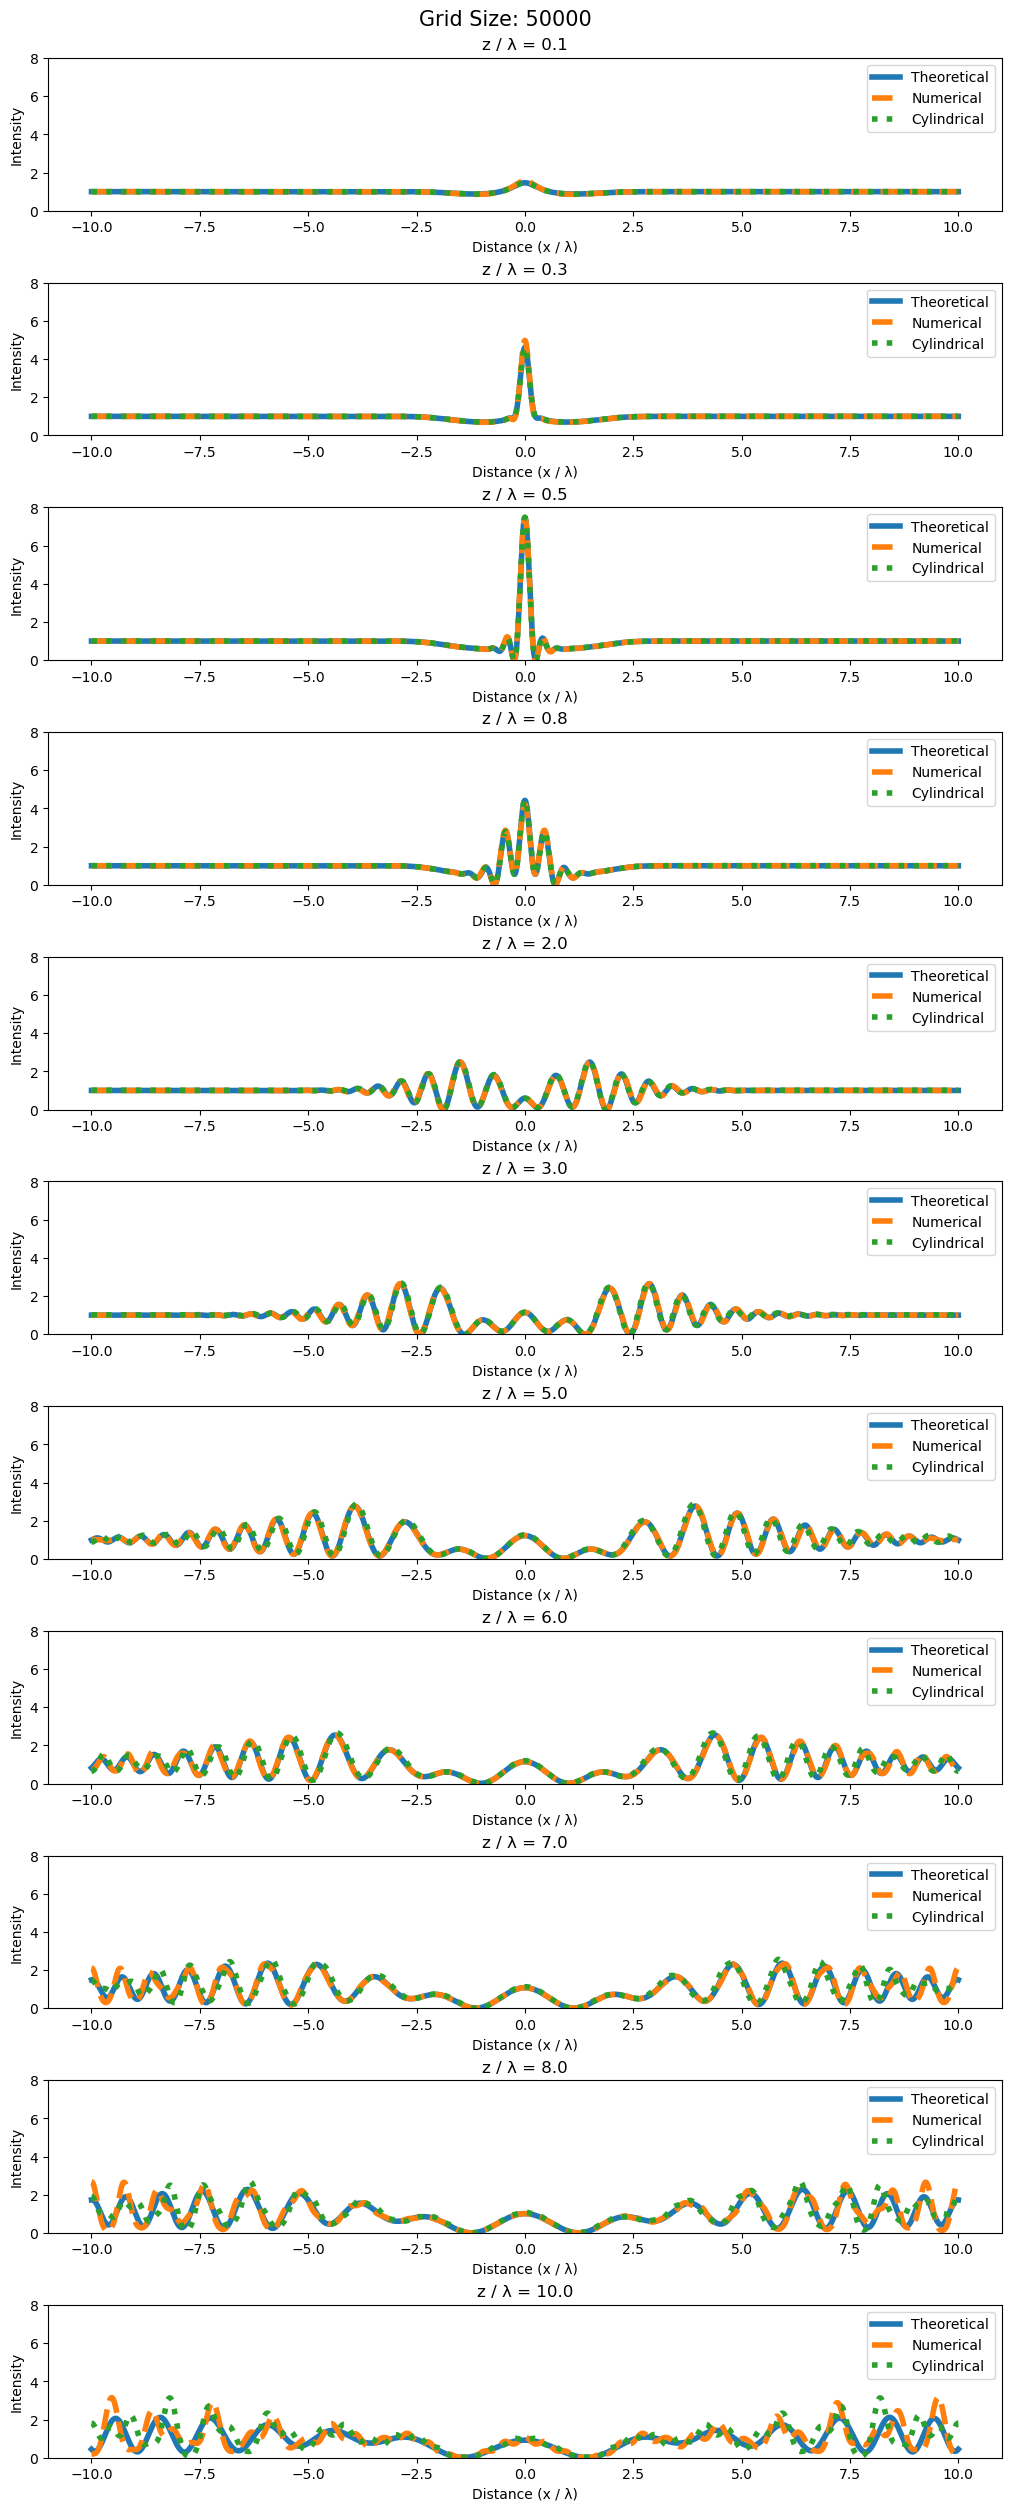

In [104]:
results_plot = PlotResults(phase_screen_dec, e_theoretical, phase_screen_cyl)
results_plot.plot_results()  


In [113]:
    class RelativeErrors:
        def __init__(self, phase_screen_dec, e_theoretical, phase_screen_cyl):
    
            self.phase_screen_dec = phase_screen_dec
            self.e_theoretical = e_theoretical
            self.phase_screen_cyl = phase_screen_cyl
            
            
        def compute_relative_errors(self):
            
            # Cartesian relative error
            theoretical_results_dec = np.array(self.e_theoretical.calculate_E_theoretical())  
            numerical_results_dec = np.array(self.phase_screen_dec.fourier_propagation())     
            abs_diff_cartesian = np.abs(numerical_results_dec - theoretical_results_dec)
            abs_theoretical_cartesian = np.abs(theoretical_results_dec)
            max_error_cartesian = np.max(abs_diff_cartesian / abs_theoretical_cartesian) * 100
            mean_error_cartesian = np.mean(abs_diff_cartesian / abs_theoretical_cartesian) * 100

            # Cylindrical relative error
            numerical_results_cyl = np.array(self.phase_screen_cyl.generation_of_phase_screen_cyl())  
            abs_diff_cylindrical = np.abs(numerical_results_cyl - theoretical_results_dec)
            abs_theoretical_cylindrical = np.abs(theoretical_results_dec)
            max_error_cylindrical = np.max(abs_diff_cylindrical / abs_theoretical_cylindrical) * 100
            mean_error_cylindrical = np.mean(abs_diff_cylindrical / abs_theoretical_cylindrical) * 100

            return (
                {'max': max_error_cartesian, 'mean': mean_error_cartesian},
                {'max': max_error_cylindrical, 'mean': mean_error_cylindrical}
            )



        def plot_relative_errors(self, dx_values):
    
        
            
            cartesian_errors_max = {z: [] for z in self.phase_screen_dec.Z_lambda}
            cylindrical_errors_max = {z: [] for z in self.phase_screen_dec.Z_lambda}
            cartesian_errors_mean = {z: [] for z in self.phase_screen_dec.Z_lambda}
            cylindrical_errors_mean = {z: [] for z in self.phase_screen_dec.Z_lambda}
            dtheta = {z: [] for z in self.phase_screen_dec.Z_lambda}

            for z_lambda in self.phase_screen_dec.Z_lambda:
                for dx in dx_values:
                    
                    grid_size = int(self.phase_screen_dec.L / dx)

                    # Create updated Cartesian phase screen and theoretical results for the current Z_lambda
                    updated_phase_screen_dec = PhaseScreenDec(self.phase_screen_dec.wavelength,
                                                            self.phase_screen_dec.phi0,
                                                            self.phase_screen_dec.r0,
                                                            grid_size,
                                                            self.phase_screen_dec.L,
                                                            [z_lambda])  # Single Z_lambda
                    updated_theoretical = ETheoretical(updated_phase_screen_dec)

                    # Create updated Cylindrical phase screen for the current Z_lambda
                    updated_phase_screen_cyl = PhaseScreenCyl(self.phase_screen_cyl.wavelength,
                                                            self.phase_screen_cyl.phi0,
                                                            grid_size,
                                                            self.phase_screen_cyl.R,
                                                            self.phase_screen_cyl.Grid_theta,
                                                            self.phase_screen_cyl.r,
                                                            self.phase_screen_cyl.dr_lambda,
                                                            self.phase_screen_cyl.r0)
                    
                    
                    dtheta[z_lambda].append(updated_phase_screen_cyl.dtheta)

                    # Compute relative errors for updated configurations
                    rel_err_calc = RelativeErrors(updated_phase_screen_dec, updated_theoretical, updated_phase_screen_cyl)
                    errors_dec, errors_cyl = rel_err_calc.compute_relative_errors()

                    
                    cartesian_errors_max[z_lambda].append(errors_dec['max'])
                    cylindrical_errors_max[z_lambda].append(errors_cyl['max'])

                    
                    cartesian_errors_mean[z_lambda].append(errors_dec['mean'])
                    cylindrical_errors_mean[z_lambda].append(errors_cyl['mean'])

            
            fig, axs = plt.subplots(4, 1, figsize=(12, 20))

            
            axs[0].set_title("Cartesian coordinates")
            axs[0].set_xlabel(r"dx/ λ ")
            axs[0].set_ylabel('Maximum Relative Error  (%)')
            for z_lambda, errors in cartesian_errors_max.items():
                axs[0].plot(np.divide(dx_values,self.phase_screen_dec.wavelength), errors, label=f'Max Errors (Z_lambda={z_lambda})', marker='o')
            axs[0].legend(loc='best', fontsize='small', ncol=2)
            axs[0].grid(True)

            
            axs[1].set_title("Cartesian coordinates")
            axs[1].set_xlabel(r"dx/ λ ")
            axs[1].set_ylabel('Mean Relative Error (%)')
            for z_lambda, errors in cartesian_errors_mean.items():
                axs[1].plot(np.divide(dx_values,self.phase_screen_dec.wavelength), errors, label=f'Mean Errors (Z_lambda={z_lambda})', marker='o')
            axs[1].legend(loc='best', fontsize='small', ncol=2)
            axs[1].grid(True)
            
            axs[2].set_title("Cylindrical coordinates")
            axs[2].set_xlabel(r"d𝜭 * R/ λ ")
            axs[2].set_ylabel('Maximum Relative Error  (%)')
            for z_lambda, errors in cylindrical_errors_max.items():
                axs[2].plot(np.divide(dtheta*self.phase_screen_cyl.R, self.phase_screen_dec.wavelength), errors, label=f'Max Errors (Z_lambda={z_lambda})', marker='x')
            axs[2].legend(loc='best', fontsize='small', ncol=2)
            axs[2].grid(True)
            
            axs[3].set_title("Cylindrical coordinates")
            axs[3].set_xlabel(r"d𝜭 * R/ λ ")
            axs[3].set_ylabel('Mean Relative Error (%)')
            for z_lambda, errors in cylindrical_errors_mean.items():
                axs[3].plot(np.divide(dtheta*self.phase_screen_cyl.R, self.phase_screen_dec.wavelength), errors, label=f'Mean Errors (Z_lambda={z_lambda})', marker='x')
            axs[3].legend(loc='best', fontsize='small', ncol=2)
            axs[3].grid(True)

            plt.tight_layout()
            plt.show()




TypeError: unsupported operand type(s) for *: 'dict' and 'int'

c:\Conda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 120621 (\N{MATHEMATICAL BOLD ITALIC CAPITAL THETA SYMBOL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Conda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 120621 (\N{MATHEMATICAL BOLD ITALIC CAPITAL THETA SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


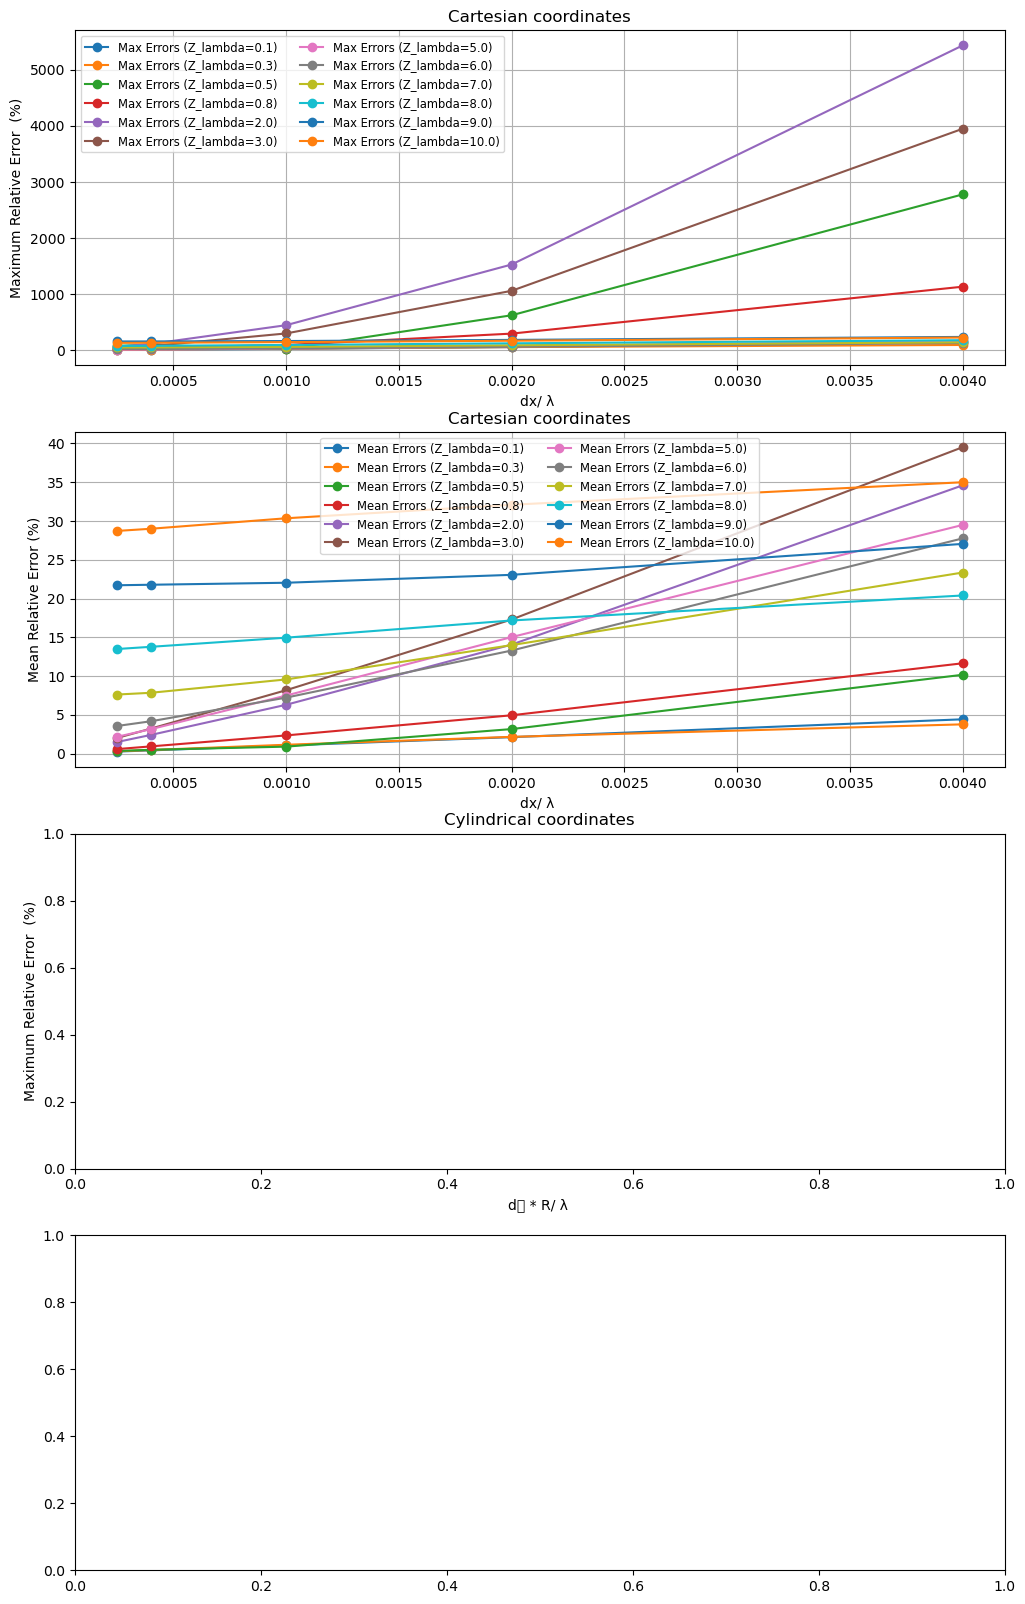

In [114]:
# Constants
R = 100  # 100 meters to source (radius of circle)
Grid_theta = 0.06  # radians
r = 100
grid_size = 50000
dr_lambda = [0.1, 0.3, 0.5, 0.8, 2.0, 3.0 , 5.0, 6.0, 7.0, 8.0 , 9.0, 10.0]
freq = 1e9
wavelength = 3e8 / freq
phi0 = 10  # phi0 in radians
r0 = wavelength
L = 6  # Length of the observation grid
Z_lambda = [0.1, 0.3, 0.5, 0.8, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0 , 9.0, 10.0]


phase_screen_dec = PhaseScreenDec(wavelength, phi0, r0, grid_size, L, Z_lambda)
e_theoretical = ETheoretical(phase_screen_dec)
phase_screen_cyl = PhaseScreenCyl(wavelength, phi0, grid_size, R, Grid_theta, r, dr_lambda, r0)


relative_errors = RelativeErrors(phase_screen_dec, e_theoretical, phase_screen_cyl)

errors_dec, errors_cyl = relative_errors.compute_relative_errors()


dx_values =  [ L / 5000, L / 10000, L / 20000, L / 50000 , L / 80000]  
relative_errors.plot_relative_errors(dx_values)
